<a href="https://colab.research.google.com/github/NetaYinon26/projects/blob/main/learning_task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LOAD AND PREPROCESS DATA**

In [5]:

import os
import glob
import random
import shutil
import numpy as np
import scipy.io
import tarfile
import requests
from collections import defaultdict

# Constants
SEED = 42
TRAIN_RATIO = 0.5
VAL_RATIO = 0.25
TEST_RATIO = 0.25

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

def download_and_extract(images_url, labels_url):
    """
    Downloads and extracts image files and labels

    Args:
        images_url (str): URL for the image archive
        labels_url (str): URL for the labels file

    Returns:
        tuple: Path to images directory and labels file
    """
    images_archive = "102flowers.tgz"
    labels_file = "imagelabels.mat"

    # Download images
    if not os.path.exists(images_archive):
        print("Downloading images...")
        response = requests.get(images_url, stream=True)
        with open(images_archive, "wb") as f:
            f.write(response.content)

    # Extract images
    if not os.path.exists("flowers"):
        print("Extracting images...")
        os.makedirs("flowers", exist_ok=True)
        with tarfile.open(images_archive, "r:gz") as tar:
            tar.extractall(path="flowers")

    # Download labels
    if not os.path.exists(labels_file):
        print("Downloading labels...")
        response = requests.get(labels_url, stream=True)
        with open(labels_file, "wb") as f:
            f.write(response.content)

    return "flowers/jpg", labels_file

def load_and_validate_data(image_dir, labels_file):
    """
    Loads and validates images and their labels

    Args:
        image_dir (str): Directory containing the images
        labels_file (str): Path to the labels file

    Returns:
        tuple: List of image files and their corresponding labels
    """
    # Load labels
    label_data = scipy.io.loadmat(labels_file)
    labels = label_data['labels'][0]

    # Find all image files
    image_files = sorted(glob.glob(os.path.join(image_dir, 'image_*.jpg')))

    # Verify matching number of images and labels
    assert len(image_files) == len(labels), \
           f"Mismatch: found {len(image_files)} images but {len(labels)} labels."

    return image_files, labels

def organize_by_class(image_files, labels):
    """
    Organizes images by their class

    Args:
        image_files (list): List of image file paths
        labels (list): List of corresponding labels

    Returns:
        defaultdict: Dictionary mapping class IDs to lists of image files
    """
    class_files = defaultdict(list)
    for img_file, label in zip(image_files, labels):
        class_files[label].append(img_file)
    return class_files

def create_balanced_split(output_dir, class_files, run_index=1):
    """
    Creates a balanced split of the data by class

    Args:
        output_dir (str): Base directory for output
        class_files (dict): Dictionary mapping class IDs to image files
        run_index (int): Index for this split run

    Returns:
        str: Path to the created split directory
    """
    split_dir = os.path.join(output_dir, f"flower_split_run{run_index}")
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)

    # Create directory structure
    for subset in ['train', 'val', 'test']:
        for class_idx in range(1, 103):
            os.makedirs(os.path.join(split_dir, subset, str(class_idx)), exist_ok=True)

    # Perform balanced splitting for each class
    for class_id, files in class_files.items():
        # Shuffle files
        random.shuffle(files)

        # Calculate split sizes
        n_files = len(files)
        n_train = int(n_files * TRAIN_RATIO)
        n_val = int(n_files * VAL_RATIO)

        # Split into groups
        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        # Copy files to appropriate directories
        for f in train_files:
            shutil.copy(f, os.path.join(split_dir, 'train', str(class_id)))
        for f in val_files:
            shutil.copy(f, os.path.join(split_dir, 'val', str(class_id)))
        for f in test_files:
            shutil.copy(f, os.path.join(split_dir, 'test', str(class_id)))

    print(f"Finished balanced splitting (run #{run_index}) into {split_dir}")
    return split_dir

def verify_split(split_dir):
    """
    Verifies the split and prints statistics

    Args:
        split_dir (str): Directory containing the split datasets
    """
    stats = {}
    for subset in ['train', 'val', 'test']:
        stats[subset] = defaultdict(int)
        for class_dir in os.listdir(os.path.join(split_dir, subset)):
            n_files = len(os.listdir(os.path.join(split_dir, subset, class_dir)))
            stats[subset][class_dir] = n_files

    print("\nSplit Statistics:")
    for subset in ['train', 'val', 'test']:
        total = sum(stats[subset].values())
        print(f"{subset}: {total} images")
        print(f"Average per class: {total/102:.1f}")
        print(f"Min in class: {min(stats[subset].values())}")
        print(f"Max in class: {max(stats[subset].values())}\n")

def main():
    # Dataset URLs
    images_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

    # Download and extract data
    image_dir, labels_file = download_and_extract(images_url, labels_url)

    # Load and validate data
    image_files, labels = load_and_validate_data(image_dir, labels_file)

    # Organize by class
    class_files = organize_by_class(image_files, labels)

    # Create balanced split
    split_dir = create_balanced_split("flower_splits", class_files)

    # Verify and output statistics
    verify_split(split_dir)

if __name__ == "__main__":
    main()


Extracting images...
Finished balanced splitting (run #1) into flower_splits/flower_split_run1

Split Statistics:
train: 4070 images
Average per class: 39.9
Min in class: 20
Max in class: 129

val: 2009 images
Average per class: 19.7
Min in class: 10
Max in class: 64

test: 2110 images
Average per class: 20.7
Min in class: 10
Max in class: 65



# **TRAINING AND PLOTS FOR VGG19**

Found 4070 images belonging to 102 classes.
Found 2009 images belonging to 102 classes.
Found 2110 images belonging to 102 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.0119 - loss: 5.2891 - val_accuracy: 0.0239 - val_loss: 4.5808
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 103s 802ms/step - accuracy: 0.0209 - loss: 4.5665 - val_accuracy: 0.0567 - val_loss: 4.4333
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 96s 745ms/step - accuracy: 0.0395 - loss: 4.4474 - val_accuracy: 0.1304 - val_loss: 3.9961
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 101s 789ms/step - accuracy: 0.1025 - loss: 4.1257 - val_accuracy: 0.2270 - val_loss: 3.5689
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 101s 786ms/step - accuracy: 0.1976 - loss: 3.6339 - val_accuracy: 0.3733 - val_loss: 2.9295
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 102s 799ms/step - accuracy: 0.2954 - loss: 3.1096 - val_accuracy: 0.4739 - val_loss: 2.4276
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 155s 901ms/step - accuracy: 0.3866 - loss: 2.6635 - val_accuracy: 0.5495 - val_loss: 1.9511
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 132s 825ms/step - accuracy: 0.4666 - los

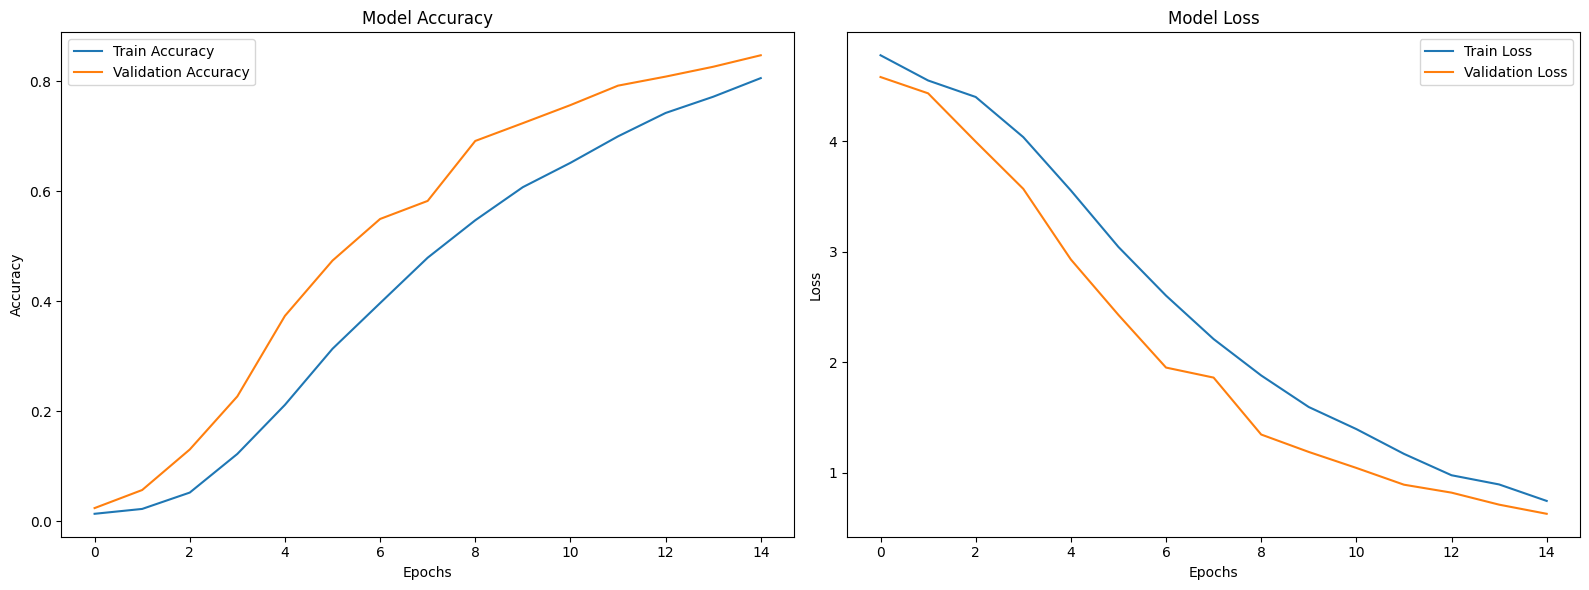

In [6]:
# Imports and setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt

# GPU setup and memory configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

# Parameters setting
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Data generators setup
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def load_data_generators(split_dir):
    train_generator = train_datagen.flow_from_directory(
        directory=f'{split_dir}/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        directory=f'{split_dir}/val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        directory=f'{split_dir}/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

# Load data generators
train_generator_run, val_generator_run, test_generator_run = load_data_generators('/content/flower_splits/flower_split_run1')

def build_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(102, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.00001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Train model
model = build_model()
checkpoint_run = ModelCheckpoint("model_run1.keras", monitor='val_accuracy', save_best_only=True, mode='max')

# Train and save history
history_run = model.fit(
    train_generator_run,
    validation_data=val_generator_run,
    epochs=EPOCHS,
    callbacks=[checkpoint_run]
)

# Save history
with open('history_run1.pkl', 'wb') as f:
    pickle.dump(history_run.history, f)

# Plot function
def plot_training_history(history, epochs_range):
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Create plots
plot_training_history(history_run, range(EPOCHS))

# **VGG19 TEST**

In [4]:
# Load the best model
best_model = tf.keras.models.load_model("model_run1.keras")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator_run, verbose=1)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - accuracy: 0.8247 - loss: 0.6817

Test Results:
Test Loss: 0.6317
Test Accuracy: 0.8431


# **VGG19 model summary**

In [7]:
import tensorflow as tf
def print_model_summary():
    # Load the best model
    best_model = tf.keras.models.load_model("model_run1.keras")

    # Print the model summary
    best_model.summary()

# Call the function to print the summary
print_model_summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 61,962,740 (236.37 MB)

 Trainable params: 20,654,246 (78.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,308,494 (157.58 MB)

# **TRAINING AND PLOTS FOR YOLOv5**


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17270/17270), 16.10 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (11855/11855), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s

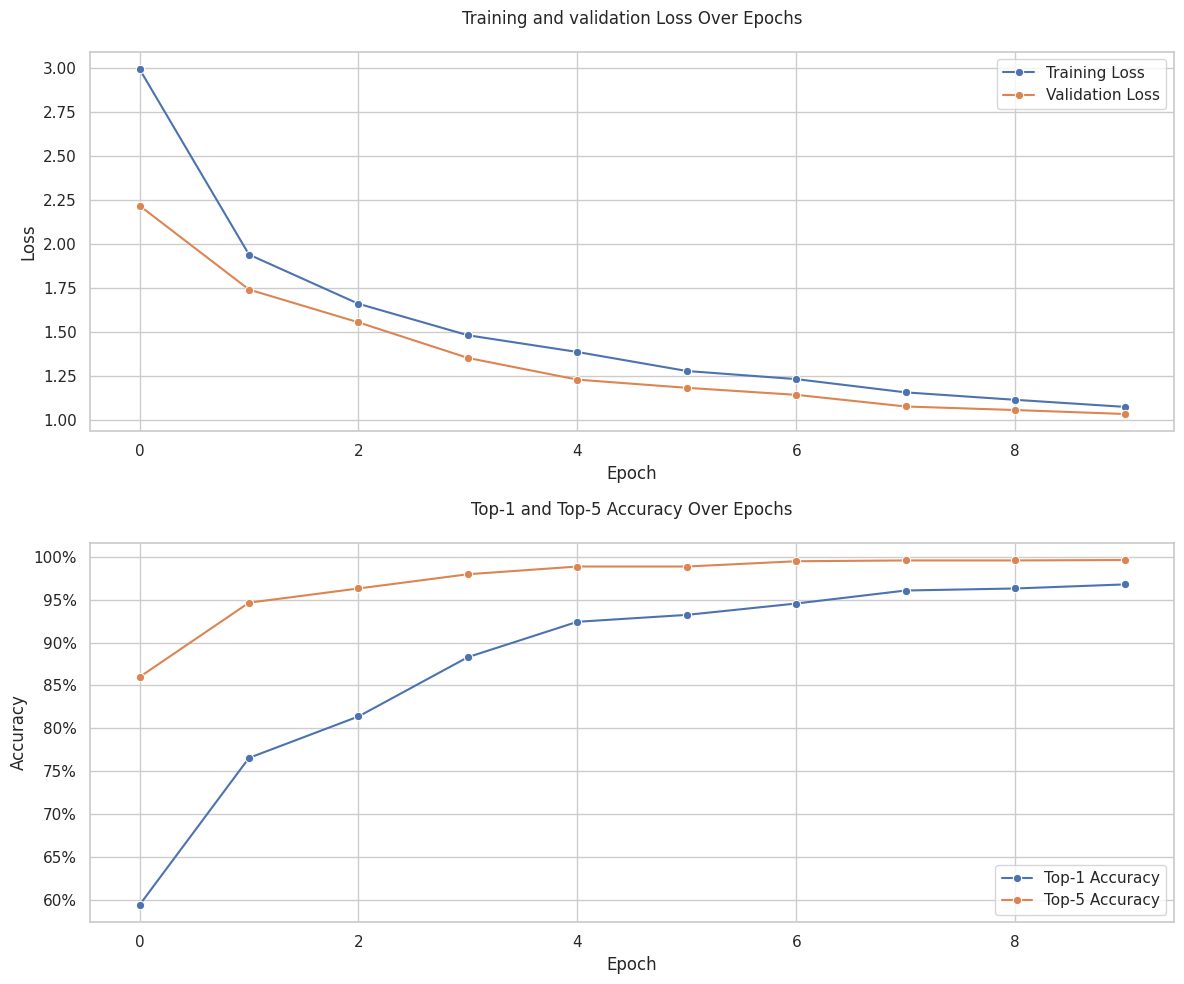

Model saved to /content/final_yolov5_cls_run1.pt


In [8]:

import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%cd /content


# 1. Clone YOLOv5 Repository (if not exists)
if not os.path.exists("yolov5"):
    !git clone https://github.com/ultralytics/yolov5

# 2. Navigate to YOLOv5 directory and install requirements
%cd yolov5
!pip install -qr requirements.txt

# 3. Download YOLOv5 classification model (if not exists)
if not os.path.exists("yolov5s-cls.pt"):
    !wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s-cls.pt -O yolov5s-cls.pt

# 4. Clean previous run directories (prevent run*2)
!rm -rf runs/train-cls/run1_yolov5_cls
!rm -rf runs/val-cls/run1_yolov5_cls_test

# 5. Create historical results directory (CSV, model)
results_dir = "/content/yolov5/results_history"
os.makedirs(results_dir, exist_ok=True)

# 6. Execute YOLOv5 Classification Training
!WANDB_MODE=disabled python classify/train.py \
  --model yolov5s-cls.pt \
  --data /content/flower_splits/flower_split_run1 \
  --epochs 10 \
  --img 224 \
  --batch 16 \
  --name run1_yolov5_cls \
  --project runs/train-cls

# 7. Copy training results to CSV
train_results_csv = "runs/train-cls/run1_yolov5_cls/results.csv"
csv_output_path = os.path.join(results_dir, "train_results.csv")

if os.path.exists(train_results_csv):
    os.rename(train_results_csv, csv_output_path)
    print("\nTraining Results:")
    train_results = pd.read_csv(csv_output_path)
    print(train_results.head())
else:
    print("Warning: train_results.csv not found. Check the training process.")


# 8. Visualize Training Metrics
def plot_training_metrics(results_df):
    # Clean the data - remove any leading/trailing whitespace from column names
    results_df.columns = results_df.columns.str.strip()

    # Set style
    sns.set_theme(style="whitegrid")

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Training and Test Loss
    sns.lineplot(data=results_df, x='epoch', y='train/loss',
                label='Training Loss', marker='o', ax=ax1)
    sns.lineplot(data=results_df, x='epoch', y='test/loss',
                label='Validation Loss', marker='o', ax=ax1)
    ax1.set_title('Training and validation Loss Over Epochs', pad=20)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plot 2: Top-1 and Top-5 Accuracy
    sns.lineplot(data=results_df, x='epoch', y='metrics/accuracy_top1',
                label='Top-1 Accuracy', marker='o', ax=ax2)
    sns.lineplot(data=results_df, x='epoch', y='metrics/accuracy_top5',
                label='Top-5 Accuracy', marker='o', ax=ax2)
    ax2.set_title('Top-1 and Top-5 Accuracy Over Epochs', pad=20)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    # Convert y-axis to percentage format
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Adjust layout and display
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'training_metrics.png'))
    plt.show()
    plt.close()

# Read and plot the results
results_dir = "/content/yolov5/results_history"
csv_output_path = os.path.join(results_dir, "train_results.csv")

if os.path.exists(csv_output_path):
    # Read CSV with explicit handling of whitespace
    results_df = pd.read_csv(csv_output_path, skipinitialspace=True)
    plot_training_metrics(results_df)
else:
    print("Warning: Results file not found. Cannot generate visualizations.")

# 9. Save Final Model
source_path = "runs/train-cls/run1_yolov5_cls/weights/best.pt"
destination_path = "/content/final_yolov5_cls_run1.pt"

if os.path.exists(source_path):
    shutil.copy2(source_path, destination_path)
    print(f"Model saved to {destination_path}")
else:
    print("Error: Model file not found. Please check the training process.")

## **VALIDATION YOLOv5**

In [25]:


!python classify/val.py \
  --weights runs/train-cls/run1_yolov5_cls/weights/best.pt \
  --data /content/flower_splits/flower_split_run1 \
  --img 224 \
  --batch-size 16 \
  --name run1_yolov5_cls_test \
  --project runs/val-cls \


classify/val: data=/content/flower_splits/flower_split_run1, weights=['runs/train-cls/run1_yolov5_cls/weights/best.pt'], batch_size=16, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=run1_yolov5_cls_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing:   0% 0/132 [00:00<?, ?it/s]/content/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
testing: 100% 132/132 [00:05<00:00, 22.42it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2110       0.968       0.996
                       1          10         0.9           1
                      10          12       0.917           1
   

saving results, because of built-in bug

In [30]:
# saving the test results as df
import pandas as pd
import io

output_text = """                       Class      Images    top1_acc    top5_acc
                     all        2110       0.968       0.996
                       1          10         0.9           1
                      10          12       0.917           1
                     100          13           1           1
                     101          15           1           1
                     102          12           1           1
                      11          23           1           1
                      12          23       0.957       0.957
                      13          13       0.923           1
                      14          12           1           1
                      15          13           1           1
                      16          11       0.909           1
                      17          22       0.909           1
                      18          21           1           1
                      19          13       0.923           1
                       2          15       0.933           1
                      20          14       0.786           1
                      21          10           1           1
                      22          16           1           1
                      23          24           1           1
                      24          11           1           1
                      25          11           1           1
                      26          11       0.909           1
                      27          10           1           1
                      28          17       0.941       0.941
                      29          20           1           1
                       3          10         0.8         0.8
                      30          22       0.955           1
                      31          13       0.769           1
                      32          12       0.833           1
                      33          12           1           1
                      34          10           1           1
                      35          12           1           1
                      36          20           1           1
                      37          27           1           1
                      38          14           1           1
                      39          11       0.909           1
                       4          14       0.714           1
                      40          18       0.889           1
                      41          33        0.97           1
                      42          16           1           1
                      43          33        0.97           1
                      44          24           1           1
                      45          10           1           1
                      46          49        0.98           1
                      47          18           1           1
                      48          19           1           1
                      49          13       0.923           1
                       5          17           1           1
                      50          23           1           1
                      51          65       0.985           1
                      52          22           1           1
                      53          24       0.958           1
                      54          16       0.938           1
                      55          19           1           1
                      56          28           1           1
                      57          18           1           1
                      58          29           1           1
                      59          18           1           1
                       6          12           1           1
                      60          28           1           1
                      61          13           1           1
                      62          15       0.933           1
                      63          14           1           1
                      64          13           1           1
                      65          26           1           1
                      66          16           1           1
                      67          11       0.909           1
                      68          14       0.929           1
                      69          14       0.929       0.929
                       7          10         0.9           1
                      70          16           1           1
                      71          20           1           1
                      72          24       0.917           1
                      73          49        0.98           1
                      74          44           1           1
                      75          30       0.967           1
                      76          28       0.929           1
                      77          64           1           1
                      78          35           1           1
                      79          11           1           1
                       8          22           1           1
                      80          27       0.963           1
                      81          42           1           1
                      82          28           1           1
                      83          34       0.971           1
                      84          22       0.818           1
                      85          17           1           1
                      86          15           1           1
                      87          17           1           1
                      88          39           1           1
                      89          46           1           1
                       9          12        0.75       0.917
                      90          21       0.905           1
                      91          19           1           1
                      92          17       0.941           1
                      93          12           1           1
                      94          41       0.976           1
                      95          32           1           1
                      96          24       0.833       0.958
                      97          17       0.882           1
                      98          21           1           1
                      99          17       0.882       0.941"""

df = pd.read_csv(io.StringIO(output_text), delim_whitespace=True)

# לוודא שהעמודות במספרים הן מספריות
df['Images'] = pd.to_numeric(df['Images'])
df['top1_acc'] = pd.to_numeric(df['top1_acc'])
df['top5_acc'] = pd.to_numeric(df['top5_acc'])

print("DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


DataFrame shape: (103, 4)

First few rows:
  Class  Images  top1_acc  top5_acc
0   all    2110     0.968     0.996
1     1      10     0.900     1.000
2    10      12     0.917     1.000
3   100      13     1.000     1.000
4   101      15     1.000     1.000


<ipython-input-30-a83c14cee291>:109: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(io.StringIO(output_text), delim_whitespace=True)


# *TEST LOSS CALCULATION FOR YOLOv5 MODEL*

In [34]:
import numpy as np

#based on the loss function of the training

def CrossEntropyLossCalculator(df):

  # preventing log(0) issues using epsilon
  epsilon = 1e-10

  # Exclude the "all" row
  dff = df[1:]

  # Define label smoothing factor
  label_smoothing = 0.1 # default value
  n_classes = len(dff)  # Number of classes excluding "all"

  # smoothed cross-entropy loss
  smoothed_CrossEntropyLoss = -np.sum(
      dff["Images"] * (
          (1 - label_smoothing) * np.log(dff["top1_acc"] + epsilon) +
          (label_smoothing / n_classes) * np.log(1 / n_classes + epsilon)
      )
  )

  # Compute total number of images
  total_images = dff["Images"].sum()

  # Compute expected train loss (average loss per image in a batch)
  expected_loss_score_per_epoch = smoothed_CrossEntropyLoss / total_images

  # Print the results
  print(f"CrossEntropy Loss Score: {expected_loss_score_per_epoch:.4f}")


CrossEntropyLossCalculator(df)
top1_acc_total = df.loc[0, "top1_acc"]
top5_acc_total = df.loc[0, "top5_acc"]

# Display the overall top1 and top5 accuracy percentages
top1_acc_total_precent = top1_acc_total * 100
top5_acc_total_precent = top5_acc_total * 100

print(f"Top 1 accuracy: {top1_acc_total_precent:.2f}%")
print(f"Top 5 accuracy: {top5_acc_total_precent:.2f}%")


CrossEntropy Loss Score: 0.0355
Top 1 accuracy: 96.80%
Top 5 accuracy: 99.60%


# **YOLOv5 model summary**

In [38]:
import torch

# Load the pre-trained model
model = torch.load("yolov5s-cls.pt")
print("Model Summary:")
print(model['model'])

<ipython-input-38-03c0a8afee68>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("yolov5s-cls.pt")


Model Summary:
ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace